# Supreme Court Oral Arguments

The goal of this project was to look at transcripts of the oral arguments in supreme court cases and examine if there was correlation between words/phrases and whether or not the court will vote in favor of the petitioner.  The text includes questions from the justices, and the oral arguments and answers from both the petitioner and the respondent.

The metrics are the words in the oral argument texts.  Stop words from NLTK are removed as well as common words and phases.  The next logical step would be to separate the questions and the oral arguments from each party into separate variables.  Also the number of questions asked by each justice and the justices hearing the case would be interesting metrics to examine.  The most time consuming part of the project was collecting the data and keeping the data for each case aligned.

The data is split into 80/20 train/test split.  Both the train and test data is passed through the sklearn count vectorizer, using a n-gram range of 1-3, in order for the words not included in the test data to be variables in the evaluation of the test data. Baseline for the data is 0.651. The attempt at modeling the data was a standard logistic regression and multinomial naive bayes.  

The logistic regression model was evaluated using cross validation on the test data with 5 folds.  The mean of the cross validation score is 0.583.  The next step is a multinomial Naive Bayes model.  The accuracy score for the model is 0.614 and the 5 fold cross validated score is 0.667.  

Since the first 2 models do not improve upon baseline, common phrases and words are added to the stop word list based on the most common n-grams.  The logistic regression and multinomial naive bales are run on the new words list.  The new mean cross validated 5 fold score for logistic regression is 0.634 and for naive bases is 0.646.  The results are not different enough from the first models to matter.  However, the 10 words with the highest coefficients for the logistic regression model for 1, 2, and 3 word combinations are in the next cell.

The next step was to look at decision tree classifiers and ensemble methods.  The results for these models are at the end of this notebook.  The ensemble methods are not any better than the logistic regression model.

In [294]:
gram_df

,0,1,2,3,4,5,6,7,8,9
0,proceedings,habeas,prior,corpus,south,number,bankruptcy,illinois,third,agency
1,ninth circuit,corpus proceedings,south carolina,williamson county,habeas corpus,scope employment,sixth circuit,death penalty,ten commandments,writs act
2,habeas corpus proceedings,subject matter jurisdiction,ninth circuit decision,state law claims,clearly established law,sixth amendment right,per se rule,reserve remainder time,major life activity,federal common law


time: 17.8 ms


In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep

%load_ext autotime

## Data Collection
Supreme Court case information collected from www.oyez.org using selenium to navigate the webpages and beautiful soup to extract the data. 

________________________________________

Use a range of years to create list of urls to search over

In [85]:
years = range(2000,2015)
urls = []
for year in years:
    url = 'https://www.oyez.org/cases/' + str(year)
    urls.append(url)

time: 1.9 ms


Get HTML from each year/term page and retreive links for each case

In [79]:
htmls = []
driver = webdriver.Chrome(executable_path="./chromedriver/chromedriver")
for url in urls:    
    driver.get(url)
    sleep(1)
    html = driver.page_source
    htmls.append(html)

In [80]:
#close webdriver
driver.close()

In [81]:
#beautiful soup the html
soups = []
for html in htmls:
    soup = BeautifulSoup(html, 'lxml')
    soups.append(soup)

In [87]:
#extract the urls for the court cases on each page
case_links = []
for soup in soups:
    for i in soup.find_all('a', href=True):
        if len(i['href'])>10 and 'cases/' in i['href']:            
            case_links.append('https://www.oyez.org/' + i['href'])

time: 525 ms


In [88]:
#convert to series in order to remove non case links
case_series = pd.Series(case_links)

time: 1.37 ms


In [89]:
#drop duplicates
case_series.drop_duplicates(inplace=True)

time: 3.37 ms


In [90]:
#save only case links
case_series = case_series[4:]

time: 1.14 ms


## Main data scrape
Navigate to each case page.  Save the page HTML the navigate to each audio file link and save HTML.  Save all information related to each case in one list.  

In [91]:
htmls1 = []
htmls2 = []
links = []
list_test = []
driver = webdriver.Chrome(executable_path="./chromedriver/chromedriver")
for url in case_series:    
    #go to link
    driver.get(url)
    #wait b/c javascript
    sleep(1)
    #get html
    html1 = driver.page_source
    htmls1.append(html1)
    #beatuful soup
    soup = BeautifulSoup(html1, 'lxml')
    for i in soup.find_all('a', {'class':'ng-binding ng-isolate-scope'}):
        if 'argument' in i['iframe-url']:
            if 'https://apps.oyez.org' in i['iframe-url']:
                driver.get(str(i['iframe-url']))
                links.append(str(i['iframe-url']))
                print str(i['iframe-url'])
                sleep(1)
                html2 = driver.page_source
                htmls2.append(html2)
                list_test.append([str(i['iframe-url']),html2,html1])
                

https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22757
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22864
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21446
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22074
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21413
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22162
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22528
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21796
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21541
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22698
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22682
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22883
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22006
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22571
https://apps.oyez.org/player/#/reh

https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22567
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22813
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21735
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22780
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22537
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22394
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21588
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/23551
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22569
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22161
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/23077
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22263
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22187
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22234
https://apps.oyez.org/player/#/reh

https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/23505
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21856
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/23069
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/23161
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/23512
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22355
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21739
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21697
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22650
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/23103
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21531
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/23543
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/23634
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22236
https://apps.oyez.org/player/#/reh

https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22435
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22799
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21681
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/23557
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21977
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22825
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22367
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21657
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22024
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22559
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21444
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21537
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/21548
https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22658
https://apps.oyez.org/player/#/reh

https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21987
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22714
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21416
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21728
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21393
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22224
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21678
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22352
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22257
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22802
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21328
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22039
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22756
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22818
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21933
https://ap

https://apps.oyez.org/player/#/roberts2/oral_argument_audio/23491
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22476
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22397
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21346
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22557
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22339
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22415
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22473
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21491
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22215
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21802
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/21561
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22750
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22717
https://apps.oyez.org/player/#/roberts2/oral_argument_audio/22347
https://ap

https://apps.oyez.org/player/#/roberts4/oral_argument_audio/22660
https://apps.oyez.org/player/#/roberts4/oral_argument_audio/21299
https://apps.oyez.org/player/#/roberts4/oral_argument_audio/21989
https://apps.oyez.org/player/#/roberts4/oral_argument_audio/22541
https://apps.oyez.org/player/#/roberts4/oral_argument_audio/22348
https://apps.oyez.org/player/#/roberts4/oral_argument_audio/23061
https://apps.oyez.org/player/#/roberts4/oral_argument_audio/23145
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/22372
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21694
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/22462
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21834
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23016
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/22916
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21761
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/22892
https://ap

https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23578
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21609
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/22598
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21740
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23115
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23636
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23639
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21342
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23643
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/22414
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/22233
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21370
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21808
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21627
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21858
https://ap

https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23235
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23222
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23248
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23097
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21363
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23478
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/22575
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/22684
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23475
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23696
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21544
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/22965
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23538
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/23204
https://apps.oyez.org/player/#/roberts6/oral_argument_audio/21772
https://ap

In [92]:
driver.close()

time: 92.6 ms


In [93]:
list_text2 = []
for i in list_test:
    soup1 = BeautifulSoup(i[2], 'lxml')
    soup2 = BeautifulSoup(i[1], 'lxml')
    list_text2.append([i[0],soup1,soup2])

time: 1min 12s


The data was then extraced from the html of the case page and the audio transcript page

In [129]:
list_text3 = []
for term in list_text2:
    verbage = []
    speakers = []
    audio_link = []
    docket = []
    petitioner = []
    respondent = []
    decided = []
    decision = []
    for i in term[2].find_all('section',{'ng-repeat':'turn in section.turns'}):
        verb = []
        speaker= []
        for x in i.find('h4'):
            speaker = x
        for y in i.find_all('p', {'ng-repeat':'textBlock in turn.text_blocks'}):
            verb.append(y.text)
        if len(speaker) == 0:
            speaker = np.NaN
        speakers.append(speaker)
        verbage.append(verb)  
    for i in term[1].find_all('div',{'class':'cell ng-binding'}):
        if 'Docket' in i.text:
            docket = i.text
        if 'Petitioner' in i.text:
            petitioner = i.text
        if 'Respondent' in i.text:
            respondent = i.text
    for x in term[1].find_all('a', {'class':'ng-binding ng-isolate-scope'}):  
        
        if 'oral_argument_audio' in str(x['iframe-url']):
            audio_link.append(str(x['iframe-url']))
    for y in term[1].find_all('div', {'ng-repeat':'chron in case.timeline'}):
        if 'Decided' in y.text:
            decided = y.text
    for f in term[1].find_all('span',{'ng-if':'decision.winning_party'}):
        decision = f.text
        
    list_text3.append([term[0], audio_link, docket[11:], respondent[11:], petitioner[11:], decided[9:-1], decision[5:],speakers,verbage]) 

time: 49.6 s


In [130]:
list_text3[0]

['https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22757',
 ['https://apps.oyez.org/player/#/rehnquist10/oral_argument_audio/22757'],
 u' 00-492 ',
 u' Bozeman ',
 u' Alabama ',
 u'Jun 11, 2001',
 [],
 [u'William H. Rehnquist',
  u'Sandra Jean Stewart',
  u"Sandra Day O'Connor",
  u'Sandra Jean Stewart',
  u"Sandra Day O'Connor",
  u'Sandra Jean Stewart',
  u"Sandra Day O'Connor",
  u'Sandra Jean Stewart',
  u'Anthony M. Kennedy',
  u'Sandra Jean Stewart',
  u'Anthony M. Kennedy',
  u'Sandra Jean Stewart',
  u'William H. Rehnquist',
  u'Sandra Jean Stewart',
  u'William H. Rehnquist',
  u'Sandra Jean Stewart',
  u'Antonin Scalia',
  u'Sandra Jean Stewart',
  u'Antonin Scalia',
  u'Sandra Jean Stewart',
  u'David H. Souter',
  u'Sandra Jean Stewart',
  u'David H. Souter',
  u'Sandra Jean Stewart',
  u'Stephen G. Breyer',
  u'Sandra Jean Stewart',
  u'Stephen G. Breyer',
  u'Sandra Jean Stewart',
  u'Stephen G. Breyer',
  u'Sandra Jean Stewart',
  u'Stephen G. Breyer',
  u'

time: 35.5 ms


In [131]:
df = pd.DataFrame()

time: 1.14 ms


In [132]:
list1 = []
list2 = []
list3 = []
list4 = []
list5 = []
list6 = []
list7 = []
list8 = []
list9 = []

for i in list_text3:
    list1.append(i[0])
    list2.append(i[1][0])
    list3.append(i[2])
    list4.append(i[3])
    list5.append(i[4])
    list6.append(i[5])
    list7.append(i[6])
    list8.append(i[7])
    list9.append(i[8])

time: 12 ms


In [133]:
df['link1'] = list1
df['link2'] = list2
df['docket'] = list3
df['respondent'] = list4
df['petitioner'] = list5
df['decided'] = list6
df['decision'] = list7
df['speakers'] = list8
df['verbage'] = list9

time: 10.2 ms


In [140]:
df.head(20)

,Unnamed: 0,link1,link2,docket,respondent,petitioner,decided,decision,speakers,verbage,petition_won,just_text
0,0,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,00-492,Bozeman,Alabama,"Jun 11, 2001",[],"[u'William H. Rehnquist', u'Sandra Jean Stewar...","[[u"" We'll hear argument next in number 00-492...",0,"We'll hear argument next in number 00-492, Al..."
1,1,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,99-1908,Sandoval,Alexander,"Apr 24, 2001",Alexander,"[u'William H. Rehnquist', u'Jeffrey S. Sutton'...","[[u"" We'll hear argument first this morning in...",1,We'll hear argument first this morning in Num...
2,2,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,99-1238,Bennett,Artuz,"Nov 7, 2000",[],"[u'William H. Rehnquist', u'John M. Castellano...","[[u"" We'll hear argument next in Number 99-123...",0,"We'll hear argument next in Number 99-1238, C..."
3,5,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,99-1687,Vopper,Bartnicki,"May 21, 2001",[],"[u'William H. Rehnquist', u'Jeremiah A. Collin...","[[u"" We'll hear argument next in Number 99-168...",0,"We'll hear argument next in Number 99-1687, G..."
4,6,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,00-6374,Montgomery,Becker,"May 29, 2001",Becker,"[u'William H. Rehnquist', u'Jeffrey S. Sutton'...","[[u"" We'll hear argument now in No. 00-6374, D...",1,"We'll hear argument now in No. 00-6374, Dale ..."
5,8,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,99-1964,Churner,Booth,"May 29, 2001",[],"[u'William H. Rehnquist', u'Nancy Winkelman', ...","[[u"" We'll hear argument next in Number 99-196...",0,"We'll hear argument next in Number 99-1964, T..."
6,9,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,99-901,Tennessee Secondary School Athletic Assn.,Brentwood Academy,"Feb 20, 2001",Brentwood Academy,"[u'William H. Rehnquist', u'James F. Blumstein...","[[u"" We'll hear argument next in Number 99-901...",1,"We'll hear argument next in Number 99-901, Br..."
7,12,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,99-9073,United States,Buford,"Mar 20, 2001",[],"[u'William H. Rehnquist', u'Dean A. Strang', u...","[[u"" We'll hear argument now in Number 99-9073...",0,"We'll hear argument now in Number 99-9073, Pa..."
8,15,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,00-292,Citizen Band Potawatomi Indian Tribe of Oklah...,"C. & L. Enterprises, Inc.","Apr 30, 2001","C. & L. Enterprises, Inc.","[u'William H. Rehnquist', u'John D. Mashburn',...","[[u"" We'll hear argument now in Number 00-292,...",1,"We'll hear argument now in Number 00-292, C &..."
9,16,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,00-1011,INS,Calcano-Martinez et al.,"Jun 25, 2001",Calcano-Martinez et al.,"[u'William H. Rehnquist', u'Lucas Guttentag', ...","[[u"" We'll hear argument now in Number 00-1011...",1,"We'll hear argument now in Number 00-1011, De..."


time: 79.8 ms


In [184]:
df = df[[len(i)>0 for i in df.petitioner]]

time: 2.58 ms


In [189]:
df = df[[len(i)>0 for i in df.speakers]]

time: 2.97 ms


In [190]:
df.shape

(479, 10)

time: 2.77 ms


In [136]:
wins = []
for term1,term2 in zip(df.decision, df.petitioner):
    if str(term1)[:4] in str(term2):
        win = 1
    else:
        win = 0
    wins.append(win)

time: 8.02 ms


In [137]:
df['petition_won'] = wins

time: 1.29 ms


In [138]:
df.petition_won.value_counts(dropna=False)

1    312
0    167
Name: petition_won, dtype: int64

time: 4.61 ms


In [218]:
full_text = []
for i in df.verbage:
    words = ' '
    for x in i:
        for y in x:
            words = words + y.encode('utf-8').strip()
    full_text.append(words)

time: 263 ms


In [221]:
df['just_text'] = full_text

time: 2.12 ms


In [141]:
df.to_csv('data_2000_2015.csv')

time: 744 ms


## Model Section

In [2]:
df = pd.read_csv('data_2000_2015.csv')

time: 503 ms


In [142]:
df.head()

,Unnamed: 0,link1,link2,docket,respondent,petitioner,decided,decision,speakers,verbage,petition_won,just_text
0,0,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,00-492,Bozeman,Alabama,"Jun 11, 2001",[],"[u'William H. Rehnquist', u'Sandra Jean Stewar...","[[u"" We'll hear argument next in number 00-492...",0,"We'll hear argument next in number 00-492, Al..."
1,1,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,99-1908,Sandoval,Alexander,"Apr 24, 2001",Alexander,"[u'William H. Rehnquist', u'Jeffrey S. Sutton'...","[[u"" We'll hear argument first this morning in...",1,We'll hear argument first this morning in Num...
2,2,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,99-1238,Bennett,Artuz,"Nov 7, 2000",[],"[u'William H. Rehnquist', u'John M. Castellano...","[[u"" We'll hear argument next in Number 99-123...",0,"We'll hear argument next in Number 99-1238, C..."
3,5,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,99-1687,Vopper,Bartnicki,"May 21, 2001",[],"[u'William H. Rehnquist', u'Jeremiah A. Collin...","[[u"" We'll hear argument next in Number 99-168...",0,"We'll hear argument next in Number 99-1687, G..."
4,6,https://apps.oyez.org/player/#/rehnquist10/ora...,https://apps.oyez.org/player/#/rehnquist10/ora...,00-6374,Montgomery,Becker,"May 29, 2001",Becker,"[u'William H. Rehnquist', u'Jeffrey S. Sutton'...","[[u"" We'll hear argument now in No. 00-6374, D...",1,"We'll hear argument now in No. 00-6374, Dale ..."


time: 30.7 ms


In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

time: 3.92 ms


In [144]:
X = df.just_text
y = df.petition_won

time: 1.22 ms


In [145]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = .8)

time: 2.64 ms


In [146]:
cvt = CountVectorizer(ngram_range=(1,5), stop_words='english')
Xcvt = cvt.fit_transform(X_train)
test_cvt = cvt.transform(X_test)

lr = LogisticRegression()
lr.fit(Xcvt,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

time: 1min 8s


In [191]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr, test_cvt, y_test, cv=5).mean()

0.5831578947368421

time: 8.01 s


In [148]:
#BASELINE
df.petition_won.mean()

0.651356993736952

time: 2.44 ms


In [149]:
nb = MultinomialNB()
nb.fit(Xcvt, y_train)
y_pred_class = nb.predict(test_cvt)

print metrics.accuracy_score(y_test, y_pred_class)

0.614583333333
time: 515 ms


In [192]:
cross_val_score(nb, test_cvt, y_test, cv=5).mean()

0.66701754385964906

time: 1.39 s


### Add common phrases and words to stopwords and then retrain models

In [150]:
from nltk.corpus import stopwords
from collections import Counter
stop = stopwords.words('english')
more_stop = [ 'counsel', 'case', 'submitted','hear' ,'argument', 'next','united', 'states','mr','honor', 
             'chief' ,'justice' ,'may', 'please' ,'court','thank','minutes', 'remaining','would','think','well',
            'one','the','that','acquiescence','platonic','relegates','indemnifies','10374','timbuktu','syracuse',
             'nonjurisdiction','clogged','excesses','to39']
stop = stop + more_stop

time: 5.21 ms


In [151]:
#for seeing common words/phrases
vect = CountVectorizer(ngram_range=(1,3), stop_words=stop)

summaries = ''.join(df.just_text)
ngram_sum = vect.build_analyzer()(summaries)

Counter(ngram_sum).most_common(20)

[(u'say', 12666),
 (u'state', 12318),
 (u'question', 11092),
 (u'could', 10203),
 (u'statute', 10169),
 (u'said', 9715),
 (u'right', 9486),
 (u'congress', 9350),
 (u'law', 9342),
 (u'whether', 8468),
 (u'know', 8386),
 (u'going', 8170),
 (u'federal', 7497),
 (u'rule', 7162),
 (u'government', 7086),
 (u'mean', 6649),
 (u'cases', 6645),
 (u'yes', 6418),
 (u'point', 6300),
 (u'way', 6245)]

time: 8.96 s


In [320]:
cvt = CountVectorizer(ngram_range=(1,3), stop_words=stop,strip_accents='unicode',analyzer = 'word')
Xvect = cvt.fit(X_train)
Xcvt = cvt.fit_transform(X_train)
test_cvt = cvt.transform(X_test)

time: 36.2 s


In [321]:
lr2 = LogisticRegression()
lr2.fit(Xcvt,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

time: 2.28 s


In [322]:
y_pred = lr2.predict(test_cvt)

time: 8.26 ms


In [325]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 15,  64],
       [ 36, 125]])

time: 3.81 ms


In [326]:
from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.29      0.19      0.23        79
          1       0.66      0.78      0.71       161

avg / total       0.54      0.58      0.56       240

time: 3.46 ms


In [327]:
from sklearn.metrics import roc_curve, auc

time: 1.02 ms


In [328]:
Y_pp = pd.DataFrame(lr2.predict_proba(test_cvt), columns=['class_0_pp','class_1_pp'])
Y_pp.head()

,class_0_pp,class_1_pp
0,0.067346,0.932654
1,0.014231,0.985769
2,0.764761,0.235239
3,0.998056,0.001944
4,0.983915,0.016085


time: 15.1 ms


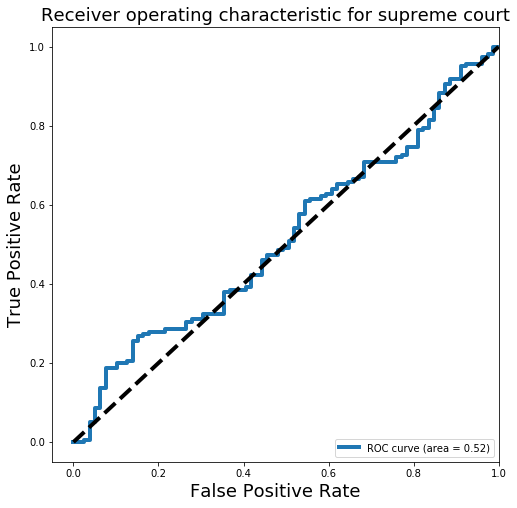

time: 232 ms


In [330]:
# For class 1, find the area under the curve
fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for supreme court', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [259]:
cross_val_score(lr2, test_cvt, y_test, cv=5).mean()

0.59426900584795328

time: 2.35 s


In [260]:
coef_series = pd.Series(lr2.coef_[0])

time: 1.01 ms


In [261]:
feature_df = pd.DataFrame()
feature_df['coef'] = coef_series
feature_df['name'] = cvt.get_feature_names()

time: 4 s


In [262]:
feature_df.sort_values(by='coef', ascending=True).head()

,coef,name
313680,-0.056876,de novo review
1348206,-0.056069,year day rule
159369,-0.051286,bright line rule
107104,-0.049096,article iii judge
466141,-0.049001,felony drug offense


time: 317 ms


In [263]:
feature_df['abs_coef'] = [abs(i) for i in feature_df.coef]

time: 515 ms


In [264]:
feature_df.sort_values(by='abs_coef', ascending=False).head(10).name.values

array([u'habeas corpus proceedings', u'subject matter jurisdiction',
       u'ninth circuit decision', u'state law claims',
       u'clearly established law', u'sixth amendment right',
       u'per se rule', u'reserve remainder time', u'major life activity',
       u'federal common law'], dtype=object)

time: 315 ms


In [246]:
# ngram1 = feature_df.sort_values(by='abs_coef', ascending=False).head(10).name.values

time: 6.02 ms


In [266]:
ngram1

array([u'proceedings', u'habeas', u'prior', u'corpus', u'south', u'number',
       u'bankruptcy', u'illinois', u'third', u'agency'], dtype=object)

time: 3.01 ms


In [256]:
# ngram2 = feature_df.sort_values(by='abs_coef', ascending=False).head(10).name.values

time: 195 ms


In [267]:
ngram2

array([u'ninth circuit', u'corpus proceedings', u'south carolina',
       u'williamson county', u'habeas corpus', u'scope employment',
       u'sixth circuit', u'death penalty', u'ten commandments',
       u'writs act'], dtype=object)

time: 2.71 ms


In [265]:
# ngram3 = feature_df.sort_values(by='abs_coef', ascending=False).head(10).name.values

time: 303 ms


In [268]:
ngram3

array([u'habeas corpus proceedings', u'subject matter jurisdiction',
       u'ninth circuit decision', u'state law claims',
       u'clearly established law', u'sixth amendment right',
       u'per se rule', u'reserve remainder time', u'major life activity',
       u'federal common law'], dtype=object)

time: 3.45 ms


In [214]:
nb2 = MultinomialNB()
nb2.fit(Xcvt, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

time: 196 ms


In [215]:
cross_val_score(nb2, test_cvt, y_test, cv=5).mean()

0.64596491228070174

time: 823 ms


In [288]:
gram1 = pd.Series(ngram1, index=range(0,10))
gram2 = pd.Series(ngram2, index=range(0,10))
gram3 = pd.Series(ngram3, index=range(0,10))

time: 3.03 ms


In [293]:
# gram_df = pd.DataFrame([gram1,gram2,gram3])

time: 3.24 ms


Try new model

In [303]:
stop = stopwords.words('english')
more_stop = [ 'counsel', 'case', 'submitted','hear' ,'argument', 'next','united', 'states','mr','honor', 
             'chief' ,'justice' ,'may', 'please' ,'court','thank','minutes', 'remaining','would','think','well',
            '10374','to39']
stop = stop + more_stop

time: 3.74 ms


In [304]:
X = df.just_text
y = df.petition_won

time: 1.23 ms


In [316]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = .5)


time: 2.12 ms


In [317]:
cvt = CountVectorizer(ngram_range=(1,4), stop_words=stop, strip_accents='unicode' , analyzer = 'word')
Xcvt = cvt.fit_transform(X_train)
test_cvt = cvt.transform(X_test)

time: 34.7 s


In [300]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline


time: 4.58 ms


In [183]:
Classifier1 = DecisionTreeClassifier(max_depth=1)
Classifier2 = DecisionTreeClassifier(max_depth=3)
Classifier3 = DecisionTreeClassifier(max_depth=6)
Classifier4 = DecisionTreeClassifier(max_depth=None)

Classifier1.fit(Xcvt,y_train)
Classifier2.fit(Xcvt,y_train)
Classifier3.fit(Xcvt,y_train)
Classifier4.fit(Xcvt,y_train)


print Classifier1.score(Xcvt,y_train)
print Classifier2.score(Xcvt,y_train)
print Classifier3.score(Xcvt,y_train)
print Classifier4.score(Xcvt,y_train)

print '____________________'
print cross_val_score(Classifier1, test_cvt ,y_test,cv=5).mean()
print cross_val_score(Classifier2, test_cvt ,y_test,cv=5).mean()
print cross_val_score(Classifier3, test_cvt ,y_test,cv=5).mean()
print cross_val_score(Classifier4, test_cvt ,y_test,cv=5).mean()

0.681462140992
0.741514360313
0.809399477807
1.0
____________________
0.560409356725
0.562105263158
0.623742690058
0.582105263158
time: 1min 30s


In [187]:
RClassifier1 = RandomForestClassifier(max_depth=1)
RClassifier2 = RandomForestClassifier(max_depth=3)
RClassifier3 = RandomForestClassifier(max_depth=6)
RClassifier4 = RandomForestClassifier(max_depth=None)

RClassifier1.fit(Xcvt,y_train)
RClassifier2.fit(Xcvt,y_train)
RClassifier3.fit(Xcvt,y_train)
RClassifier4.fit(Xcvt,y_train)


print RClassifier1.score(Xcvt,y_train)
print RClassifier2.score(Xcvt,y_train)
print RClassifier3.score(Xcvt,y_train)
print RClassifier4.score(Xcvt,y_train)

print '____________________'
print cross_val_score(RClassifier1, test_cvt ,y_test,cv=5).mean()
print cross_val_score(RClassifier2, test_cvt ,y_test,cv=5).mean()
print cross_val_score(RClassifier3, test_cvt ,y_test,cv=5).mean()
print cross_val_score(RClassifier4, test_cvt ,y_test,cv=5).mean()

0.65274151436
0.657963446475
0.699738903394
0.98955613577
____________________
0.645964912281
0.655964912281
0.645964912281
0.645964912281
time: 16.1 s


In [334]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(Xcvt, y_train)


time: 54.4 s


In [336]:
clf.score(test_cvt.toarray(), y_test)

0.62083333333333335

time: 3.58 s
